In [261]:
import pandas as pd
import numpy as np
import math
import scipy.stats as si
import random
import pickle
import time
pd.options.display.max_rows = 1200
PATH = 'https://raw.githubusercontent.com/hmku/mwtc-2020/master/MWTC-platform-release-1.1.1/data/normalized_price_paths/{}_{}.csv'

In [48]:
n = 100
dfs = [{'history': pd.read_csv(PATH.format('history', i), index_col=0, header=0).transpose(), 
        'trading': pd.read_csv(PATH.format('trading', i), index_col=0, header=0).transpose()}
       for i in range(n)]
dfs

[{'history':                A           B          C           D           E           F  \
  0      93.339227   92.758675  76.310948  134.862406  121.352739  307.466850   
  1      93.754714   92.271097  75.975936  133.839470  121.801187  308.719590   
  2      92.949430   91.963232  76.437248  132.777294  121.305722  306.743513   
  3      92.386261   91.693289  76.718947  132.016991  121.759779  308.127726   
  4      92.851503   91.214735  76.426019  131.012683  120.910414  309.537807   
  ...          ...         ...        ...         ...         ...         ...   
  1795  100.620792   99.645514  99.095019  100.510042   99.721102  101.802008   
  1796   99.679377  100.027050  99.954433   99.981936  100.055451  102.437784   
  1797   99.239868  100.348189  99.054865   99.365975  100.373771  102.962102   
  1798   99.874762  100.001275  98.190607  100.007968  100.765002  102.066621   
  1799  100.409590   99.623853  99.236732  100.559569  100.410556  100.859786   
  
              

In [13]:
# helper function for plotting
def plot(df, *args, cs=False):
    if len(args) == 0:
        args = list(df.columns)
    dft = pd.DataFrame()
    for arg in args:
        dft[arg] = df[arg].cumsum() if cs else df[arg]
    dft.plot(figsize=(15, 10), y=args)

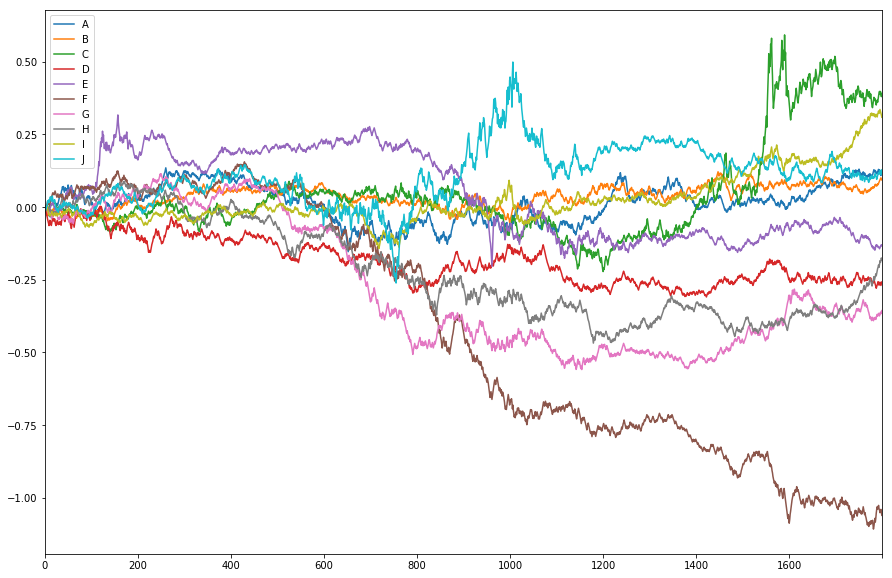

In [30]:
plot(dfs[0]['history'].pct_change(), cs=True)

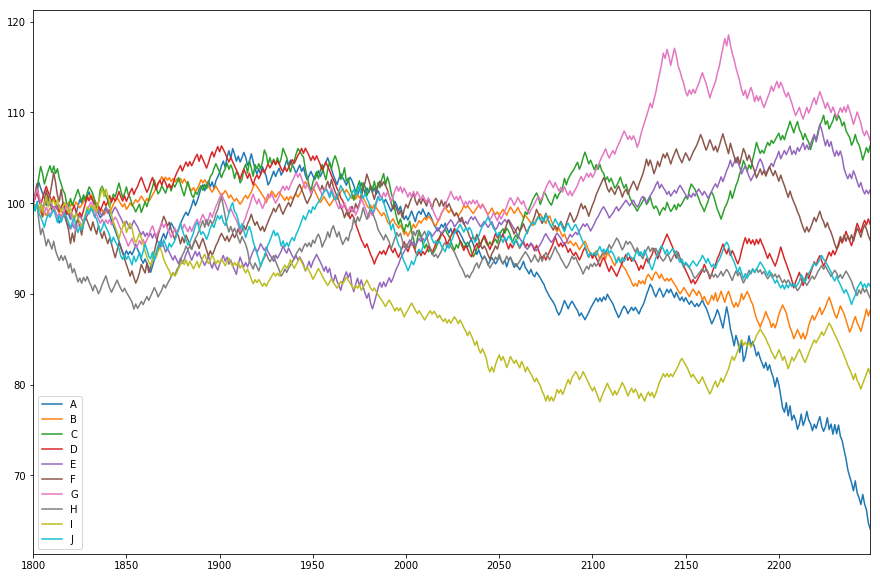

In [254]:
plot(dfs[0]['trading'])

In [49]:
vols = [{'history': dfs[i]['history'].pct_change().std()*math.sqrt(1799),
        'trading': dfs[i]['trading'].pct_change().std()*math.sqrt(1799)}
       for i in range(n)]
vols

[{'history': A    0.306821
  B    0.208555
  C    0.504975
  D    0.266952
  E    0.335822
  F    0.327382
  G    0.297978
  H    0.296788
  I    0.238726
  J    0.513464
  dtype: float64, 'trading': A    0.303019
  B    0.197690
  C    0.277426
  D    0.230952
  E    0.215380
  F    0.275134
  G    0.231548
  H    0.230355
  I    0.246272
  J    0.235112
  dtype: float64}, {'history': A    0.187284
  B    0.246022
  C    0.284291
  D    0.196072
  E    0.204228
  F    0.224069
  G    0.210729
  H    0.191431
  I    0.194797
  J    0.189612
  dtype: float64, 'trading': A    0.222671
  B    0.298404
  C    0.281129
  D    0.208031
  E    0.252489
  F    0.207989
  G    0.191832
  H    0.240140
  I    0.193760
  J    0.189793
  dtype: float64}, {'history': A    0.293204
  B    0.271198
  C    0.361094
  D    0.311588
  E    0.283198
  F    0.260243
  G    0.281231
  H    0.379528
  I    0.279939
  J    0.280220
  dtype: float64, 'trading': A    0.271384
  B    0.208385
  C    0.377426
  

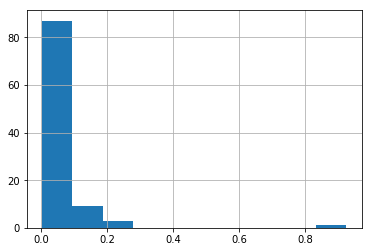

In [52]:
total_diffs = [np.sum((vol['history'] - vol['trading'])**2) for vol in vols]
pd.Series(total_diffs).hist()

In [61]:
diffs_by_tx = sum([(vol['history'] - vol['trading'])**2 for vol in vols]) / n
diffs_by_tx_sd = np.std(np.array([(vol['history'] - vol['trading'])**2 for vol in vols]), axis=0)
dft = pd.DataFrame()
dft['diff'] = diffs_by_tx
dft['sd'] = diffs_by_tx_sd
dft

,diff,sd
A,0.008583,0.020754
B,0.005362,0.020752
C,0.011696,0.087816
D,0.004783,0.017652
E,0.004005,0.012407
F,0.004583,0.011742
G,0.003286,0.005619
H,0.002834,0.004513
I,0.003239,0.006043
J,0.006975,0.019833


### test lookback windows for rolling vols

In [105]:
df0 = pd.concat([dfs[0]['history'], dfs[0]['trading']]).pct_change().dropna()
df0

,A,B,C,D,E,F,G,H,I,J
1,0.004451,-0.005256,-0.004390,-0.007585,0.003695,0.004074,-0.004396,-0.005196,0.003519,0.002892
2,-0.008589,-0.003337,0.006072,-0.007936,-0.004068,-0.006401,-0.006305,-0.008485,-0.004483,-0.009014
3,-0.006059,-0.002935,0.003685,-0.005726,0.003743,0.004513,0.003816,0.002888,-0.003156,0.002705
4,0.005036,-0.005219,-0.003818,-0.007607,-0.006976,0.004576,0.005815,0.005684,0.004932,0.005305
5,-0.007341,-0.005996,0.003249,-0.004331,0.005399,0.005572,-0.004587,0.007075,-0.003942,0.005573
...,...,...,...,...,...,...,...,...,...,...
2245,0.016701,0.009355,-0.008841,0.008664,-0.007567,0.008244,-0.008133,0.007427,0.007432,-0.006630
2246,-0.015511,0.008561,0.006148,0.005126,-0.004816,0.005967,-0.004392,-0.005525,0.006695,0.004013
2247,-0.009568,0.010502,0.006936,-0.005128,0.004194,-0.005028,0.005117,0.003676,0.006873,-0.005121
2248,-0.021533,-0.008651,-0.005139,0.006923,-0.004002,-0.007112,-0.004539,-0.005961,0.007345,0.005907


In [100]:
# get array of vols for the past [lookback] days (will be useful for actual bot)
def rolling_vol(df, lookback):
    return df.tail(lookback).std()*math.sqrt(1800)

# get sumsq difference between two pandas series (only for testing purposes)
def sumsqdiff(s1, s2):
    return np.sum((s1 - s2)**2)

# get array of vols for the next [d] days (only for testing purposes)
def future_vol(df, d):
    return df.head(d).std()*math.sqrt(1800)

rolling_vol(df0_hist, 10)

A    0.280411
B    0.154608
C    0.400431
D    0.254229
E    0.163591
F    0.340637
G    0.228517
H    0.328145
I    0.313630
J    0.283589
dtype: float64

In [133]:
d = 100
trials = 20
max_lookback = 1200
all_scores = {}
min_idxs = {}
for d in range(30, 450, 30):
    scores = np.zeros(max_lookback - 2)
    for trial in range(trials):
        print(d, trial)
        r = random.randint(max_lookback + 100, 2200 - d) # play it safe on the bounds
        scores += np.array([sumsqdiff(rolling_vol(df0[:r], lookback), future_vol(df0[r:], d)) for lookback in range(2, max_lookback)])
    all_scores[d] = scores
    min_idxs[d] = np.argmin(scores)
min_idxs

30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
60 0
60 1
60 2
60 3
60 4
60 5
60 6
60 7
60 8
60 9
60 10
60 11
60 12
60 13
60 14
60 15
60 16
60 17
60 18
60 19
90 0
90 1
90 2
90 3
90 4
90 5
90 6
90 7
90 8
90 9
90 10
90 11
90 12
90 13
90 14
90 15
90 16
90 17
90 18
90 19
120 0
120 1
120 2
120 3
120 4
120 5
120 6
120 7
120 8
120 9
120 10
120 11
120 12
120 13
120 14
120 15
120 16
120 17
120 18
120 19
150 0
150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
150 10
150 11
150 12
150 13
150 14
150 15
150 16
150 17
150 18
150 19
180 0
180 1
180 2
180 3
180 4
180 5
180 6
180 7
180 8
180 9
180 10
180 11
180 12
180 13
180 14
180 15
180 16
180 17
180 18
180 19
210 0
210 1
210 2
210 3
210 4
210 5
210 6
210 7
210 8
210 9
210 10
210 11
210 12
210 13
210 14
210 15
210 16
210 17
210 18
210 19
240 0
240 1
240 2
240 3
240 4
240 5
240 6
240 7
240 8
240 9
240 10
240 11
240 12
240 13
240 14
240 15
240 16
240 17
240 18
240 19
270 0
270 1
270 2
27

{30: 33,
 60: 10,
 90: 34,
 120: 27,
 150: 211,
 180: 10,
 210: 205,
 240: 30,
 270: 74,
 300: 18,
 330: 16,
 360: 40,
 390: 7,
 420: 41}

In [136]:
with open('vol_pred_scores', 'wb+') as file:
    pickle.dump(all_scores, file)

In [137]:
all_scores

{30: array([7.30818556, 5.03974557, 3.42445081, ..., 8.18791875, 8.18694477,
        8.18516657]),
 60: array([6.41231724, 2.94428502, 1.68565638, ..., 4.55062946, 4.5506874 ,
        4.55228075]),
 90: array([11.58227278,  6.2054693 ,  5.85635315, ...,  6.32351622,
         6.32181168,  6.32068399]),
 120: array([7.33833705, 3.92682659, 2.99549305, ..., 5.2846398 , 5.28205411,
        5.28098565]),
 150: array([10.94113476,  8.6090365 ,  8.31029004, ...,  6.18955671,
         6.18817341,  6.18857315]),
 180: array([10.72229736,  7.02403969,  5.31206269, ...,  7.57652135,
         7.57483112,  7.57288937]),
 210: array([16.03856481,  9.63522291, 12.4161519 , ...,  6.18946888,
         6.18701283,  6.18421415]),
 240: array([11.80475639,  6.88334644,  5.63932303, ...,  9.22979143,
         9.23132622,  9.23125083]),
 270: array([21.54155207, 10.03529339,  6.8083206 , ...,  6.56492351,
         6.56259084,  6.56090893]),
 300: array([11.67021697, 11.82761432,  7.79175447, ...,  6.7058633

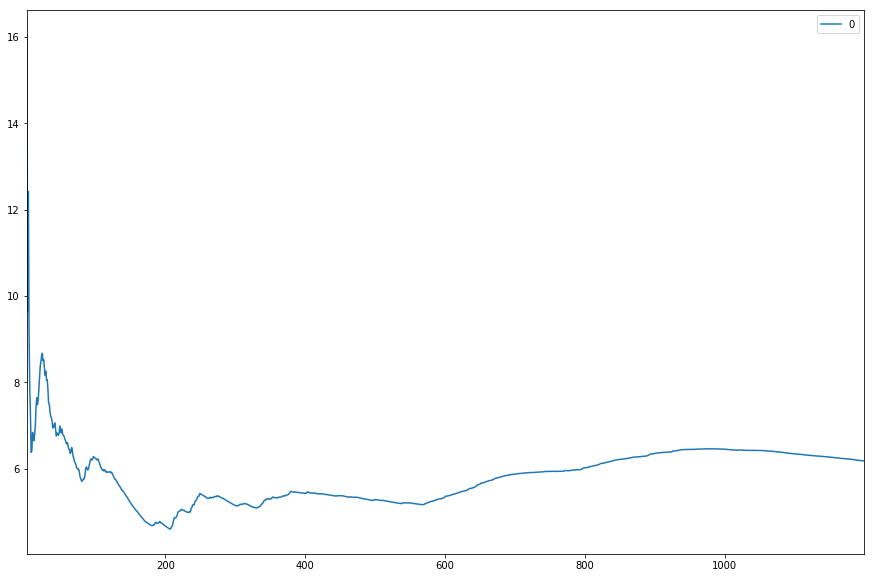

In [181]:
plot(pd.DataFrame(all_scores[210], index=list(range(2, max_lookback))))

In [180]:
total_scores = [0 for i in range(1200)]
total_scores[0], total_scores[1] = 999, 999
for i in range(2, 1200):
    total_scores[i] = np.sum(np.array([all_scores[d][i-2] for d in range(30, 450, 30)])**2)
weird_score = np.sum(np.array([all_scores[d][max(5, (d-2)//6)] for d in range(30, 450, 30)])**2)
print(weird_score)
print(np.argmin(np.array(total_scores)))
total_scores

250.0831165259904
44


[999,
 999,
 2440.705908919034,
 919.6970054365611,
 724.9777524357924,
 484.4097897083875,
 379.02213864542676,
 315.5453766091285,
 285.01027395815663,
 280.5638586003047,
 259.3058647913355,
 251.89161124837676,
 254.03261808244304,
 256.89686040154936,
 257.2822277921229,
 254.9400532398187,
 259.82684042163555,
 256.34322398225385,
 264.92127524548704,
 271.87647500306565,
 273.84567959256304,
 276.6851163581099,
 274.7450314169843,
 281.80128531472275,
 286.6467729331948,
 280.38849941113625,
 275.624449695851,
 271.6395988894037,
 266.28163275106385,
 263.10799339319675,
 259.0607074586802,
 260.355982729959,
 253.79243699366785,
 248.46795350053583,
 248.05225401709026,
 243.74622967173923,
 241.5391653405594,
 239.51373400267923,
 238.94428582218322,
 233.9478841818626,
 231.92730153081385,
 230.80846828565143,
 227.96819408595437,
 227.3844012638701,
 226.70678957506962,
 229.51654344966295,
 229.6482770101052,
 229.20848377073378,
 232.62786649038446,
 233.84786806741428,
 2

### this is the code that goes into example bot

In [220]:
from statistics import stdev
data_path = 'https://raw.githubusercontent.com/hmku/mwtc-2020/master/MWTC-platform-release-1.1.1/data/normalized_price_paths/history_0.csv'

df_p = pd.read_csv(data_path, index_col=0, header=0)
df_r = df_p.transpose().pct_change().dropna().transpose()

# get array of vols for the past [lookback] days (will be useful for actual bot)
def rolling_vol(df, lookback):
    return df.tail(lookback).std()*math.sqrt(1800)

# on market update
def market_update():
    stock_prices = [] # figure out what the stock prices are for that tick
    df_r.loc[len(df_vols)] = stock_prices

total_updates = 450
# get volatility level for that ticker
def gen_vol_level(tx, num_updates):
    return rolling_vol(df_r, max(5, (total_updates - num_updates) // 6))[tx]

# gen_vol_level('A', 450)

In [227]:
df_p.transpose().pct_change()

,A,B,C,D,E,F,G,H,I,J
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.004451,-0.005256,-0.004390,-0.007585,0.003695,0.004074,-0.004396,-0.005196,0.003519,0.002892
2,-0.008589,-0.003337,0.006072,-0.007936,-0.004068,-0.006401,-0.006305,-0.008485,-0.004483,-0.009014
3,-0.006059,-0.002935,0.003685,-0.005726,0.003743,0.004513,0.003816,0.002888,-0.003156,0.002705
4,0.005036,-0.005219,-0.003818,-0.007607,-0.006976,0.004576,0.005815,0.005684,0.004932,0.005305
...,...,...,...,...,...,...,...,...,...,...
1795,-0.006024,0.004067,-0.008911,0.005905,0.003616,-0.009045,0.005555,0.012808,0.006689,0.007152
1796,-0.009356,0.003829,0.008673,-0.005254,0.003353,0.006245,0.006651,-0.005748,-0.006005,-0.007105
1797,-0.004409,0.003211,-0.009000,-0.006161,0.003181,0.005118,-0.004670,0.005881,-0.005916,-0.006963
1798,0.006398,-0.003457,-0.008725,0.006461,0.003898,-0.008697,0.006343,0.009346,-0.006822,0.012278


In [222]:
l = df_r.to_numpy().tolist()
stdev(l[0][len(l[0]) - 45:])*math.sqrt(1800)

0.2575812154655903

### price options using black-scholes

In [302]:
# create normal cdf table
table = pd.Series([si.norm.cdf(i, 0.0, 1.0) for i in np.arange(-4, 4, 0.001)])
table

0       0.000032
1       0.000032
2       0.000032
3       0.000032
4       0.000032
          ...   
7995    0.999968
7996    0.999968
7997    0.999968
7998    0.999968
7999    0.999968
Length: 8000, dtype: float64

In [321]:
table.to_csv('normal_cdf.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [326]:
pd.read_csv('normal_cdf.csv', index_col=0, names='p').iloc[:,0]

0       0.000032
1       0.000032
2       0.000032
3       0.000032
4       0.000032
          ...   
7995    0.999968
7996    0.999968
7997    0.999968
7998    0.999968
7999    0.999968
Name: p, Length: 8000, dtype: float64

In [320]:
def option_pricer(cp_flag, S, K, T, v, r=0, q=0.0):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #v: volatility of underlying asset

    start = time.time()
    spots = np.full(18, S)
    cp = np.concatenate([np.full(9, 1), np.full(9, -1)])
    d1 = ((np.log(spots / K) + (r + 0.5 * v * v) * T) / (v * np.sqrt(T))) * cp
    d2 = ((np.log(spots / K) + (r - 0.5 * v * v) * T) / (v * np.sqrt(T))) * cp
    d1_ind = np.clip((d1 + 4) * 1000, 0, 7999).astype(int)
    d2_ind = np.clip((d2 + 4) * 1000, 0, 7999).astype(int)
    cdfd1 = table[d1_ind].to_numpy()
    cdfd2 = table[d2_ind].to_numpy()
    result = (S * cdfd1 - K * cdfd2) * cp
    print((time.time() - start)*1000)
    return result

S = 105
K = list(range(70, 160, 10)) + list(range(70, 160, 10))
T = 0.23
v = 0.3
np.set_printoptions(suppress=True)
print(option_pricer([], S, K, T, v))

3.9649009704589844
[35.00889171 25.15003489 16.01623508  8.71714998  3.9888793   1.54124794
  0.51134396  0.14881324  0.03650206  0.00889146  0.15003307  1.01623191
  3.71714622  8.98888189 16.54125295 25.51134696 35.14881485 45.03649702]


In [263]:
min([dfs[i]['trading'].min().min() for i in range(100)])

13.973395112535016

In [8]:
from multiprocessing import Pool

with Pool(5) as p:
    t = p.starmap(func, [(1, 2)])
t

[3]

In [3]:
def func(a, b):
    return a + b